## Transfer Learning Inception V3 using Keras

Please download the dataset from the below url

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [6]:
!nvidia-smi

Fri May 28 01:02:33 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [8]:
# import the libraries as shown below

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

In [3]:
import os
os.listdir('/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test')

['diseased cotton leaf',
 'diseased cotton plant',
 'fresh cotton leaf',
 'fresh cotton plant']

In [2]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train'
valid_path = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test'


# Data Imbalaced

In [4]:
import pandas as pd
from sklearn.utils import shuffle

In [5]:
import seaborn as sns

## Data train Imbalance

In [9]:
def dataframe(ds_leaf, ds_plant, fs_plant, fs_leaf):
  disease_leaf = []
  target_ds_leaf = []
  for i in os.listdir(ds_leaf):
    pic = os.path.join(ds_leaf + "/", i)
    disease_leaf.append(pic)
    target_ds_leaf.append("disease_leaf")   

  disease_plant = []
  target_ds_plant = []
  for i in os.listdir(ds_plant):
    pic = os.path.join(ds_plant + "/", i)
    disease_plant.append(pic)
    target_ds_plant.append("disease_plant")

  fresh_leaf = []
  target_fs_leaf = []
  for i in os.listdir(fs_leaf):
    pic = os.path.join(fs_leaf + "/", i)
    fresh_leaf.append(pic)
    target_fs_leaf.append("fresh_leaf")

  fresh_plant = []
  target_fs_plant = []
  for i in os.listdir(fs_plant):
    pic = os.path.join(fs_plant + "/", i)
    fresh_plant.append(pic)
    target_fs_plant.append("fresh_plant")

  dleaf = pd.DataFrame()
  dleaf["image"] = disease_leaf
  dleaf["target"] = target_ds_leaf

  dplant = pd.DataFrame()
  dplant["image"] = disease_plant
  dplant["target"] = target_ds_plant

  fleaf = pd.DataFrame()
  fleaf["image"] = fresh_leaf
  fleaf["target"] = target_fs_leaf

  fplant = pd.DataFrame()
  fplant["image"] = fresh_plant
  fplant["target"] = target_fs_plant

  return dleaf, dplant, fleaf, fplant

In [10]:
ds_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/diseased cotton leaf'
ds_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/diseased cotton plant'
fs_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/fresh cotton leaf'
fs_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/fresh cotton plant'

In [11]:
dleaf, dplant, fleaf, fplant = dataframe(ds_leaf, ds_plant, fs_plant, fs_leaf)
data_train = pd.concat([dleaf, dplant, fleaf, fplant], axis = 0, ignore_index = True)
data_train = shuffle(data_train)
data_train.head()

,image,target
538,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_plant
874,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_plant
333,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_plant
659,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_plant
1914,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_plant


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


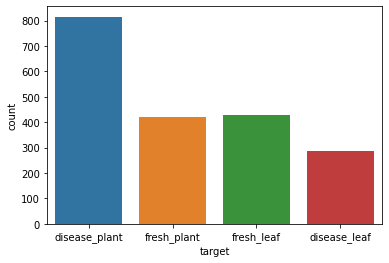

In [12]:
sns.countplot(data_train["target"])

In [21]:
data_train.target.value_counts()

disease_plant    815
fresh_leaf       427
fresh_plant      421
disease_leaf     288
Name: target, dtype: int64

In [22]:
X = data_train.drop('target',axis='columns')
y = data_train['target']

In [25]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='minority')
X_sm, y_sm = smote.fit_sample(X, y)

y_sm.value_counts()

ValueError: ignored

## Data Val Imbalanced

In [16]:
ds_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/val/diseased cotton leaf'
ds_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/val/diseased cotton plant'
fs_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/val/fresh cotton leaf'
fs_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/val/fresh cotton plant'

dleaf, dplant, fleaf, fplant = dataframe(ds_leaf, ds_plant, fs_plant, fs_leaf)
data_val = pd.concat([dleaf, dplant, fleaf, fplant], axis = 0, ignore_index = True)
data_val = shuffle(data_val)
data_val.head()

,image,target
139,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_leaf
19,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_leaf
241,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_plant
227,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_plant
239,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_plant


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


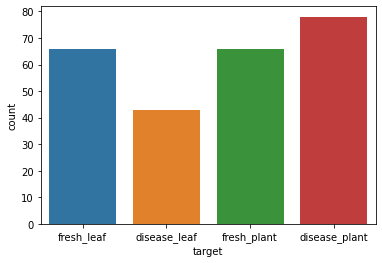

In [17]:
sns.countplot(data_val["target"])

## Data Test Imbalanced

In [18]:
ds_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test/diseased cotton leaf'
ds_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test/diseased cotton plant'
fs_leaf = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test/fresh cotton leaf'
fs_plant = '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/test/fresh cotton plant'

dleaf, dplant, fleaf, fplant = dataframe(ds_leaf, ds_plant, fs_plant, fs_leaf)
data_test = pd.concat([dleaf, dplant, fleaf, fplant], axis = 0, ignore_index = True)
data_test = shuffle(data_test)
data_test.head()

,image,target
69,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_leaf
3,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_leaf
55,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_leaf
54,/content/drive/MyDrive/Dataset/cotton-disease-...,fresh_leaf
35,/content/drive/MyDrive/Dataset/cotton-disease-...,disease_plant


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


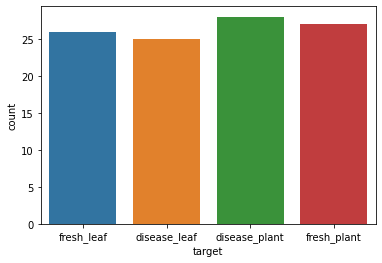

In [19]:
sns.countplot(data_test["target"])

# Model Building

In [10]:
# Import the InceptionV3 library as shown below and add preprocessing layer to the front of InceptionV3
# Here we will be using imagenet weights

inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)




In [11]:
# don't train existing weights
for layer in inception.layers:
    layer.trainable = False

In [12]:
glob('/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/*')

['/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/diseased cotton leaf',
 '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/diseased cotton plant',
 '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/fresh cotton leaf',
 '/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/fresh cotton plant']

In [13]:
  # useful for getting number of output classes
folders = glob('/content/drive/MyDrive/Dataset/cotton-disease-dataset/Cotton Disease/train/*')

In [14]:
# our layers - you can add more if you want
x = Flatten()(inception.output)

In [15]:
prediction = Dense(len(folders), activation='softmax')(x)

# create a model object
model = Model(inputs=inception.input, outputs=prediction)

In [16]:

# view the structure of the model
model.summary()


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [16]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(1e-06),
  metrics=['accuracy']
)


In [3]:
# Use the Image Data Generator to import the images from the dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [4]:
# Make sure you provide the same target size as initialied for the image size
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [6]:
training_set.class_indices

{'diseased cotton leaf': 0,
 'diseased cotton plant': 1,
 'fresh cotton leaf': 2,
 'fresh cotton plant': 3}

In [5]:
test_set = test_datagen.flow_from_directory(valid_path,
                                            target_size = (224, 224),
                                            batch_size = 64,
                                            class_mode = 'categorical')

Found 106 images belonging to 4 classes.


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor= 'val_loss',
                                                 patience=3,
                                                 mode='min')

model.compile(loss='categorical_crossentropy', 
              optimizer=tf.keras.optimizers.Adam(1e-06), 
             metrics = ['accuracy'])

history = model.fit(training_set, epochs = 100,
                    validation_data = test_set,                    
                    steps_per_epoch=len(training_set),
                    validation_steps=len(test_set),
                    callbacks=[early_stopping])

Epoch 1/100
31/31 [==============================] - 44s 1s/step - loss: 1.9366 - accuracy: 0.2547 - val_loss: 1.7243 - val_accuracy: 0.2453
Epoch 2/100
31/31 [==============================] - 33s 1s/step - loss: 1.7024 - accuracy: 0.2619 - val_loss: 1.6238 - val_accuracy: 0.3491
Epoch 3/100
31/31 [==============================] - 32s 1s/step - loss: 1.5126 - accuracy: 0.3270 - val_loss: 1.5720 - val_accuracy: 0.3962
Epoch 4/100
31/31 [==============================] - 32s 1s/step - loss: 1.4708 - accuracy: 0.3644 - val_loss: 1.5238 - val_accuracy: 0.4151
Epoch 5/100
31/31 [==============================] - 32s 1s/step - loss: 1.3848 - accuracy: 0.3870 - val_loss: 1.4688 - val_accuracy: 0.4151
Epoch 6/100
31/31 [==============================] - 32s 1s/step - loss: 1.3444 - accuracy: 0.4177 - val_loss: 1.4166 - val_accuracy: 0.4057
Epoch 7/100
31/31 [==============================] - 32s 1s/step - loss: 1.2942 - accuracy: 0.4470 - val_loss: 1.3665 - val_accuracy: 0.4245
Epoch 8/100
3

In [69]:
# fit the model
# Run the cell. It will take some time to execute
# Without earlystopping
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20,
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)

Epoch 1/20
61/61 [==============================] - 39s 583ms/step - loss: 2.1209 - accuracy: 0.7483 - val_loss: 0.7274 - val_accuracy: 0.8396
Epoch 2/20
61/61 [==============================] - 33s 549ms/step - loss: 0.6442 - accuracy: 0.8872 - val_loss: 0.4076 - val_accuracy: 0.8774
Epoch 3/20
61/61 [==============================] - 34s 551ms/step - loss: 0.6554 - accuracy: 0.8929 - val_loss: 0.2161 - val_accuracy: 0.9340
Epoch 4/20
61/61 [==============================] - 33s 547ms/step - loss: 0.9071 - accuracy: 0.8883 - val_loss: 0.5485 - val_accuracy: 0.9245
Epoch 5/20
61/61 [==============================] - 33s 548ms/step - loss: 0.6104 - accuracy: 0.9113 - val_loss: 0.3116 - val_accuracy: 0.9623
Epoch 6/20
61/61 [==============================] - 33s 546ms/step - loss: 1.4079 - accuracy: 0.8775 - val_loss: 0.1421 - val_accuracy: 0.9623
Epoch 7/20
61/61 [==============================] - 34s 550ms/step - loss: 0.6463 - accuracy: 0.9293 - val_loss: 1.0386 - val_accuracy: 0.8774

In [22]:
import matplotlib.pyplot as plt

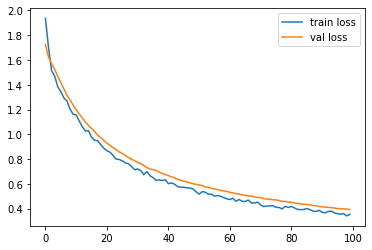

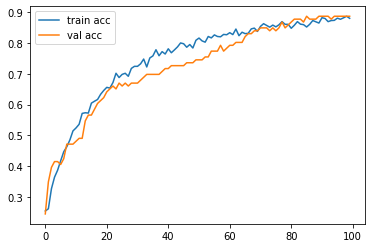

<Figure size 432x288 with 0 Axes>

In [23]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

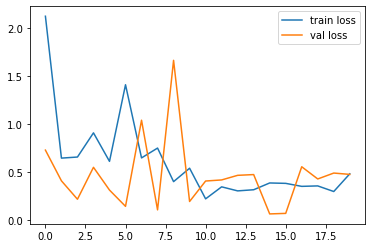

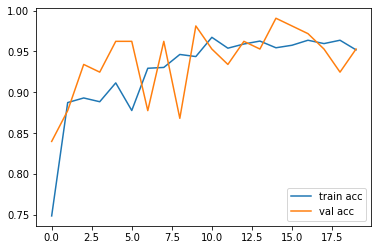

<Figure size 432x288 with 0 Axes>

In [71]:
# plot the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [39]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_inception.h5')

In [40]:
import tensorflow as tf
model = tf.keras.models.load_model('model_inception.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp8ss64k1e/assets


87948296

In [24]:
import numpy as np

from google.colab import files
from keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=image.load_img(path, target_size=(224, 224))
  
  x=image.img_to_array(img)
  x=x/255         
  x=np.expand_dims(x, axis=0)
  #images = np.vstack([x])
  x = preprocess_input(x)
  classes = model.predict(x, batch_size=10)
  
  print(classes)

Saving d (95)_iaip (1).jpg to d (95)_iaip (1) (2).jpg
Saving d (83)_iaip (1).jpg to d (83)_iaip (1) (2).jpg
Saving dis_leaf (61)_iaip.jpg to dis_leaf (61)_iaip (2).jpg
Saving dis_leaf (19)_iaip.jpg to dis_leaf (19)_iaip (2).jpg
[[0.36270306 0.2998887  0.11458426 0.22282395]]
[[0.43722343 0.18476345 0.13280827 0.24520487]]
[[0.37142736 0.28508192 0.13599443 0.20749637]]
[[0.45511922 0.24227911 0.09619898 0.20640276]]


In [43]:

y_pred = model.predict(test_set)


In [44]:
y_pred

array([[2.75549618e-11, 2.98268999e-25, 1.00000000e+00, 6.20520879e-09],
       [1.26600441e-09, 7.21061635e-32, 1.00000000e+00, 9.21034924e-18],
       [1.50026625e-03, 8.29534737e-13, 9.98499751e-01, 1.63079666e-15],
       [1.27109549e-16, 1.00000000e+00, 1.47905661e-20, 2.12719802e-13],
       [3.31734553e-12, 3.51745548e-08, 2.10060691e-10, 1.00000000e+00],
       [7.02324730e-18, 2.71154800e-03, 1.20753971e-21, 9.97288465e-01],
       [3.23519460e-03, 9.00279701e-01, 9.64851007e-02, 7.17292836e-10],
       [2.27927144e-09, 1.50186461e-05, 2.48867316e-10, 9.99984980e-01],
       [9.99999881e-01, 1.63368966e-07, 1.04726307e-16, 5.27622964e-15],
       [5.01552341e-11, 9.99979258e-01, 2.25000072e-15, 2.07127887e-05],
       [5.13117414e-14, 5.69506446e-25, 1.00000000e+00, 2.78991296e-19],
       [1.19846270e-19, 1.00000000e+00, 1.71300560e-31, 6.65607826e-23],
       [3.31217948e-20, 1.00000000e+00, 5.23521115e-22, 9.96844621e-12],
       [1.00000000e+00, 8.71395193e-21, 2.07389471e

In [45]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [46]:
y_pred

array([2, 2, 2, 1, 3, 3, 1, 3, 0, 1, 2, 1, 1, 0, 1, 0, 2, 2, 1, 1, 3, 0,
       1, 3, 2, 2, 3, 0, 0, 0, 1, 2, 0, 2, 3, 0, 2, 2, 1, 0, 3, 0, 1, 3,
       0, 1, 1, 2, 2, 0, 2, 3, 1, 1, 3, 2, 2, 0, 2, 1, 0, 2, 0, 3, 0, 2,
       2, 3, 3, 3, 3, 1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 3, 2, 3, 0, 0, 2, 1,
       3, 3, 1, 2, 2, 3, 3, 2, 1, 1, 0, 3, 0, 1, 1, 2, 2, 3])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
img_data

array([[[[ 6.7060997e+01,  5.4221001e+01,  4.7320000e+01],
         [ 6.9060997e+01,  5.6221001e+01,  4.9320000e+01],
         [ 7.3060997e+01,  6.0221001e+01,  5.3320000e+01],
         ...,
         [ 7.4060997e+01,  5.6221001e+01,  4.6320000e+01],
         [ 5.5060997e+01,  3.7221001e+01,  2.7320000e+01],
         [ 4.1060997e+01,  2.3221001e+01,  1.3320000e+01]],

        [[ 7.5060997e+01,  6.2221001e+01,  5.5320000e+01],
         [ 7.8060997e+01,  6.5221001e+01,  5.8320000e+01],
         [ 8.1060997e+01,  6.8221001e+01,  6.1320000e+01],
         ...,
         [ 9.7060997e+01,  7.9221001e+01,  6.9320000e+01],
         [ 7.3060997e+01,  5.5221001e+01,  4.5320000e+01],
         [ 4.9060997e+01,  3.1221001e+01,  2.1320000e+01]],

        [[ 8.7060997e+01,  7.4221001e+01,  6.7320000e+01],
         [ 9.0060997e+01,  7.7221001e+01,  7.0320000e+01],
         [ 9.3060997e+01,  8.0221001e+01,  7.3320000e+01],
         ...,
         [ 1.0106100e+02,  8.3221001e+01,  7.3320000e+01],
         [

In [48]:
img=image.load_img('/content/dis_leaf (61)_iaip.jpg',target_size=(224,224))



In [49]:
x=image.img_to_array(img)
x

array([[[131., 158., 105.],
        [105., 123.,  85.],
        [ 69.,  77.,  53.],
        ...,
        [ 97., 185.,  63.],
        [114., 195.,  90.],
        [132., 213., 108.]],

       [[170., 188., 150.],
        [ 84.,  97.,  71.],
        [ 58.,  62.,  48.],
        ...,
        [ 88., 176.,  53.],
        [102., 184.,  76.],
        [123., 205.,  97.]],

       [[193., 201., 177.],
        [164., 168., 154.],
        [ 57.,  56.,  54.],
        ...,
        [ 74., 163.,  35.],
        [ 85., 167.,  56.],
        [109., 191.,  80.]],

       ...,

       [[ 83.,  73.,  61.],
        [ 92.,  83.,  68.],
        [ 89.,  80.,  63.],
        ...,
        [ 69.,  64.,  61.],
        [ 98.,  90.,  69.],
        [121., 113.,  92.]],

       [[ 80.,  70.,  58.],
        [ 81.,  72.,  57.],
        [103.,  94.,  77.],
        ...,
        [ 73.,  70.,  53.],
        [ 93.,  83.,  71.],
        [122., 112., 100.]],

       [[ 76.,  66.,  54.],
        [ 85.,  76.,  61.],
        [ 93.,  

In [50]:
x.shape

(224, 224, 3)

In [51]:
x=x/255

In [52]:
import numpy as np
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [53]:
model.predict(img_data)

array([[0.24024974, 0.39257535, 0.20836815, 0.15880679]], dtype=float32)

In [34]:
a=np.argmax(model.predict(img_data), axis=1)

In [35]:
a

array([1])

In [ ]:
import tensorflow as tf